In [13]:
import pandas as pd
import numpy as np
import json
from BCBio import GFF
import pprint
import subprocess
from phytreeviz import TreeViz
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
from sklearn.metrics import adjusted_rand_score

m = ["roary","panacota","peppan","pirate","panaroo","panta","panX","panXX"]
c = list(plt.get_cmap("Set2").colors[:8])
colors=dict(zip(m,c))

In [14]:
dataset="Prochlorococcus"
organism="Prochlorococcus"
n_genomes = 40
METHODS = ["roary","panacota","panaroo","panta","peppan","panX","panXX"]

In [15]:
def get_hash(locus_list):
    locus_list.sort()
    return hash(frozenset(locus_list))

def get_idx(locus_list):
    if any("PEPPAN" in l for l in locus_list):
        return True
    else:
        return False

In [16]:
df = pd.DataFrame(columns=["methods","count","locus","hash","agreement"])
all_labels = pd.DataFrame(columns=["method","geneId","locus"])

loci = {}
for method in METHODS:
    loci[method] = [x for x in set(pd.read_json(f"bench-{organism}/{dataset}-{method}.json")["locus"].explode("locus")) if x==x]

common_loci = set()
all_loci = set()
for m,l in loci.items():
    if len(common_loci)>0:
        common_loci &= set(l)
    else:
        common_loci = set(l)
    all_loci = all_loci.union(set(l))
print(f"Found {len(all_loci)} loci")
print(f"Found {len(common_loci)} common loci")


Found 83395 loci
Found 77830 common loci


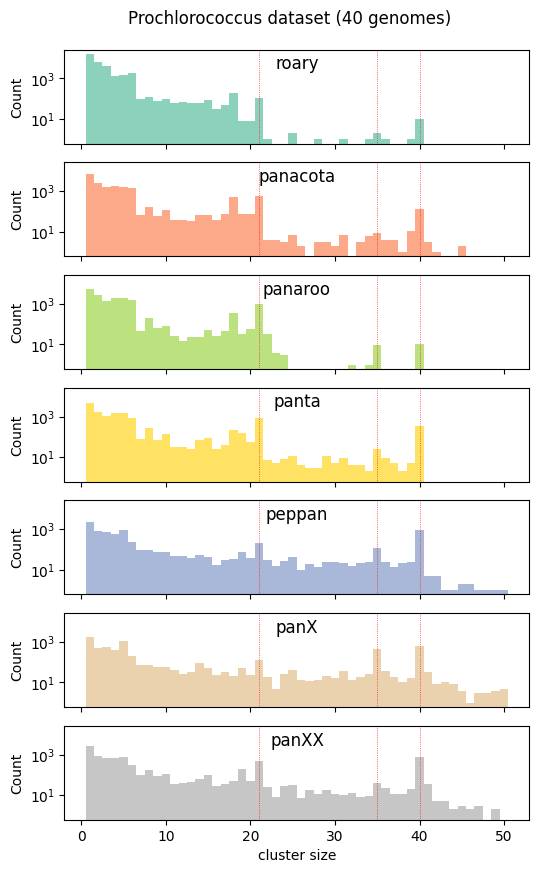

In [18]:
#------------------------------------------#
#        plot count distribution 
#       for Prochlorococcus dataset
#------------------------------------------#
fig,axes = plt.subplots(ncols=1,nrows=len(METHODS),sharex=True,sharey=True,figsize=(6,10))

MAX=50

for i in range(len(METHODS)):
    method=METHODS[i]
    counts = pd.read_json(f"bench-{organism}/{dataset}-{method}.json")["count"]
    #ignore clusters above n_genomes + 5
    c = counts[(counts>0)&(counts<=MAX)]
    ax = axes[i]
    sns.histplot(data=c,color=colors[method],edgecolor=None,ax=ax,discrete=True)
    ax.axvline(21,color="r",lw=.5,ls="dotted")
    ax.axvline(35,color="r",lw=.5,ls="dotted")
    ax.axvline(40,color="r",lw=.5,ls="dotted")
    ax.set_title(method,y=1.0,pad=-14)
    ax.set_yscale("log")
    ax.set_xlabel("cluster size")

fig.suptitle(f"Prochlorococcus dataset (40 genomes)",y=0.92)

# fig.tight_layout()

plt.show()

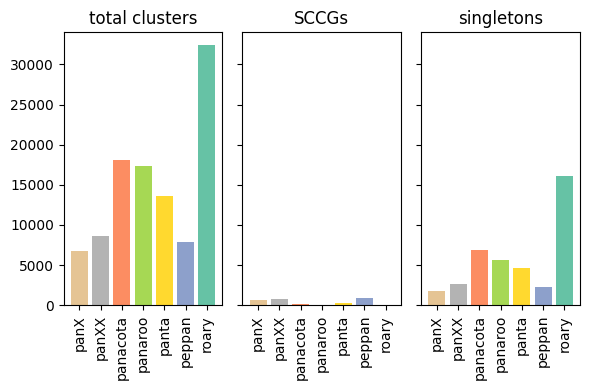

In [29]:
#------------------------------------------#
#          plot general numbers 
#        for Prochlorococcus dataset
#------------------------------------------#

c = [colors[method] for method in METHODS]
data = pd.DataFrame()

for method in METHODS:
    df = pd.read_json(f"bench-{organism}/{dataset}-{method}.json")
    sing = len(df[df["singleton"]=="yes"])
    sccg = len(df[df["sccg"]=="yes"])
    total = len(df)
    data[method] = [total,sccg,sing]

data = data.T.rename(columns={0:"total clusters",1:"sccg",2:"singleton"})

fig,axes = plt.subplots(ncols=3,nrows=1,sharex=True,sharey=True,figsize=(6,4))

axes[0].bar(data.index,data["total clusters"],color=c)
axes[0].set_title("total clusters")
axes[0].tick_params(axis="x",labelrotation=90)

axes[1].bar(data.index,data["sccg"],color=c)
axes[1].set_title("SCCGs")
axes[1].tick_params(axis="x",labelrotation=90)

axes[2].bar(data.index,data["singleton"],color=c)
axes[2].set_title("singletons")
axes[2].tick_params(axis="x",labelrotation=90)

fig.tight_layout()
fig.savefig("prochlorococcus-overview.png",dpi=300)
plt.show()



In [27]:
#-------------------------------------------#
#        collect data CC heatmap                
#-------------------------------------------#

out_df = pd.DataFrame(columns=["reference","method","concordance"])

#compute cluster hashes
print("compute cluster hashes")
locus_hash = {}
for method in METHODS:
    labels = pd.read_json(f"bench-{organism}/{dataset}-{method}.json")[["geneId","locus"]].explode("locus")
    labels = labels.query("locus in @common_loci").groupby("geneId").agg(list)
    locus_hash[method] = set(labels["locus"].apply(get_hash))

#compute concordance
print("compute concordance score")
for ref in METHODS:
    print(f"reference: {ref}")
    for method in METHODS:
        c = len(locus_hash[ref].intersection(locus_hash[method]))/len(locus_hash[method])
        out_df.loc[len(out_df)]=[ref,method,c]
print("Done!")

compute cluster hashes
compute concordance score
reference: panX
reference: panXX
reference: panacota
reference: panaroo
reference: panta
reference: peppan
reference: roary
Done!


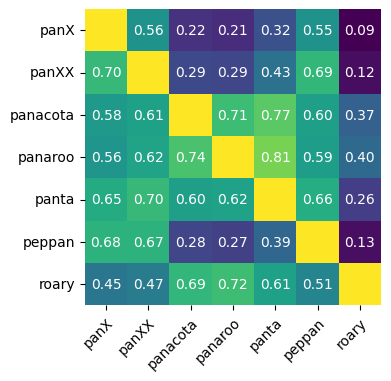

In [28]:
out_df = out_df.sort_values(by=["reference","method"],ascending=True)

concordance=out_df.concordance.to_numpy().reshape(7,7)
METHODS.sort()

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(concordance, xticklabels=METHODS,yticklabels=METHODS,cbar=False,cmap="viridis",ax=ax)

# Loop over data dimensions and create text annotations.
for i in range(7):
    for j in range(7):
        if i!=j:
            ax.text(j+0.5, i+0.5, "%0.2f" % (concordance[i, j]),horizontalalignment="center",verticalalignment="center",color="w")

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

ax.set_aspect(1)
fig.tight_layout()
fig.savefig("prochlorococcus-cc.png",dpi=300)

plt.show()

In [25]:
#-------------------------------------------#
#        collect data ARI heatmap                
#-------------------------------------------#

out_df = pd.DataFrame(columns=["reference","method","ARI"])

for ref_method in METHODS:
    print(f"reference: {ref_method}")
    ref_labels = pd.read_json(f"bench-{organism}/{dataset}-{ref_method}.json")[["geneId","locus"]].explode("locus",ignore_index=True).sort_values("locus").reset_index(drop="index")
    for method in METHODS:
        if ref_method!=method:
            method_labels = pd.read_json(f"bench-{organism}/{dataset}-{method}.json")[["geneId","locus"]].explode("locus",ignore_index=True)
            df = pd.merge(left=ref_labels,right=method_labels,how="inner",on="locus",suffixes=["_r","_m"])
            ARI=adjusted_rand_score(df["geneId_r"],df["geneId_m"])
            out_df.loc[len(out_df)]=[ref_method,method,ARI]
        else:
            out_df.loc[len(out_df)]=[ref_method,method,0]
print("Done!")

reference: panX
reference: panXX
reference: panacota
reference: panaroo
reference: panta
reference: peppan
reference: roary
Done!


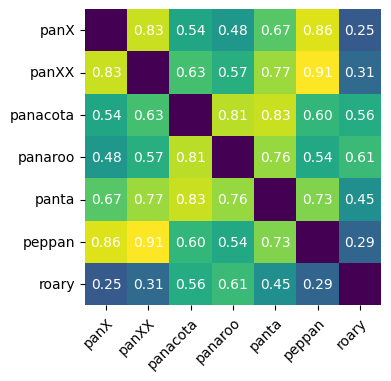

In [26]:
out_df = out_df.sort_values(by=["reference","method"],ascending=True)

ari=out_df.ARI.to_numpy().reshape(7,7)
METHODS.sort()

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(ari, xticklabels=METHODS,yticklabels=METHODS,cbar=False,cmap="viridis",ax=ax)

# Loop over data dimensions and create text annotations.
for i in range(7):
    for j in range(7):
        if i!=j:
            ax.text(j+0.5, i+0.5, "%0.2f" % (ari[i, j]),horizontalalignment="center",verticalalignment="center",color="w")

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

ax.set_aspect(1)
fig.tight_layout()

fig.savefig("prochlorococcus-ari.png",dpi=300)

plt.show()

### Additional scripts

In [ ]:
# --------------------------- #
#  find clusters of interest
# --------------------------- #

def length(l):
    if -1 in l.values:
        return len(set(l)) + 50
    else:
        return len(set(l))

dataset = "Prochlorococcus"
ref = "panaroo"
method = "panXX"


ref_df = pd.read_json(f"bench-Prochlorococcus/{dataset}-{ref}.json")
ref_df = ref_df[ref_df["sccg"]=="yes"][["geneId","locus"]].explode("locus")
method_df = pd.read_json(f"bench-Prochlorococcus/{dataset}-{method}.json")[["geneId","locus"]].explode("locus")

merge = pd.merge(left=ref_df,right=method_df,on="locus",how="left",suffixes=[ref,method]).fillna(-1)

df=merge.drop("locus",axis=1).groupby(f"geneId{ref}").agg(length)
(df[df[f"geneId{method}"]==1]).sort_values(by="geneIdpanXX",ascending=False)


In [ ]:
# --------------------------- #
#       ARI computation
# --------------------------- #

out_df = pd.DataFrame(columns=["reference","method","ARI"])

#filter by common loci
for method in METHODS:
    labels = pd.read_json(f"bench-{organism}/{dataset}-{method}.json")[["locus","geneId"]].explode("locus")
    if method=="peppan":
        # dirty fix for split up pseudogenes with identical locus tag, only keep the last occurence
        labels = labels[labels["locus"].isin(common_loci)]
        all_labels[method] = labels[~labels.duplicated("locus",keep="last")].sort_values(by="locus")["geneId"].values
    else:
        all_labels[method] = labels[(labels["locus"].isin(common_loci)) & (~labels.duplicated("locus",keep="last"))].sort_values(by="locus")["geneId"].values

#compute ARI
for ref in METHODS:
    print(f"reference: {ref}")
    for method in METHODS:
        ari = adjusted_rand_score(all_labels[ref],all_labels[method])
        out_df.loc[len(out_df)]=[ref,method,ari]
print("Done!")

out_df = out_df.sort_values(by=["reference","method"],ascending=True)

ARI=out_df.ARI.to_numpy().reshape(7,7)
METHODS.sort()

fig, ax = plt.subplots()
sns.heatmap(ARI, xticklabels=METHODS,yticklabels=METHODS,ax=ax,vmin=0.6)
ax.set_title(f"ARI - {dataset}")
ax.set_xlabel("reference")
ax.set_ylabel("method")

ax.set_aspect(1)
fig.tight_layout()

plt.show()

In [ ]:
# --------------------------- #
#      total concordance
# --------------------------- #

out_df = pd.DataFrame(columns=["reference","method","concordance"])
locus_hash = {}
dataset="Prochlorococcus"

#compute cluster hashes
for method in METHODS:
    labels = pd.read_json(f"bench-{organism}/{dataset}-{method}.json")
    if method == "peppan":
        #filter out any cluster that contains refound genes
        labels = labels["locus"]
        idx = labels.apply(get_idx)
        labels = labels[~idx]
        locus_hash[method] = set(labels.apply(get_hash))
    else:
        locus_hash[method] = set(labels["locus"].apply(get_hash))

#compute concordance
for ref in METHODS:
    print(f"reference: {ref}")
    for method in METHODS:
        c = len(locus_hash[ref].intersection(locus_hash[method]))/len(locus_hash[method])
        out_df.loc[len(out_df)]=[ref,method,c]
print("Done!")

out_df = out_df.sort_values(by=["reference","method"],ascending=True)

concordance=out_df.concordance.to_numpy().reshape(7,7)
METHODS.sort()

fig, ax = plt.subplots()
sns.heatmap(concordance, xticklabels=METHODS,yticklabels=METHODS,ax=ax)
ax.set_title("Cluster Concordance - Prochlorococcus")
ax.set_xlabel("reference")
ax.set_ylabel("method")

ax.set_aspect(1)
fig.tight_layout()

plt.show()